# A QIF analysis of Monty Hall

![](monty.png)


We play a game in which a prize is hidden behind one of three closed doors (the other two contain a goat).
- We choose one door,
- then the host opens a door __containing a goat__, among the two non-chosen ones.
- After seeing the goat we can either keep or change our initial guess.

What should we do?

How much information does this system leak?

A detailed description of the problem and its history can be found [here](https://en.wikipedia.org/wiki/Monty_Hall_problem).

In [92]:
import numpy as np
import matplotlib.pyplot as plt
try:
    from qif import *
except:
    %pip install qif
    from qif import *

The secret in this system is the door in which the prize is hidden (0, 1 or 2).

Assuming the door containing the prize is chosen uniformly at random, before we start the game we have 1/3 chances of guessing the secret correctly.

In [75]:
pi = probab.uniform(3)

print("Prior Bayes vulnerability: ", measure.bayes_vuln.prior(pi))

Prior Bayes vulnerability:  0.3333333333333333


We can model the game as the channel $A$ given below.
- __Input__: the door containing the prize (0,1 or 2)
- __Output__: the player's choice __and__ the door opened by the host.
  Eg. the output `0:1` means that the player chose door 0, and the host opened door 1.

The probabilities come directly from the rules of the game. Eg, assume that the secret is `0`:
- If the player choses the correct secret `0` the host can open either `1` or `2`, so `0:1` and `0:2` both have probability 1/6 (the host's choice is assumed to be random).
- If the player choses something else, say `1`, then the host is forced to open `2`. So `1:2` has probability 1/3 while `1:0` has probability 0.

In [89]:
A = np.array([
    #0:1  0:2  1:0  1:2  2:0  2:1
    [1/6, 1/6,   0, 1/3,   0, 1/3],        # door 0
    [  0, 1/3, 1/6, 1/6, 1/3,   0],        # door 1
    [1/3,   0, 1/3,   0, 1/6, 1/6],        # door 2
])

This system clearly leaks information, since we learn that the door opened by the host is not the one with the prize. Now there are only 2 possible doors instead of 3.

But __is this all__ we learn? Let's compute the system's multiplicative Bayes leakage.

In [77]:
print("Mult Bayes leakage =", measure.bayes_vuln.mult_leakage(pi, A))

Mult Bayes leakage = 2.0


A multiplicative leakage of 2 means that our probability of guessing the secret __doubles__ as a result of observing the system's output.
Before starting the game this probability was 1/3, so __now it becomes 2/3__!

Indeed, this is verified by computing the posterior Bayes vulnerability:

In [78]:
print("Posterior Bayes vulnerability =", measure.bayes_vuln.posterior(pi, A))

Posterior Bayes vulnerability = 0.6666666666666666


This means that we can do better than blindly choosing one of the two remaning doors. To see this, we compute below the best guess for each observable output (called a "strategy").


In [79]:
print("Best guessing strategy =", measure.bayes_vuln.strategy(pi, A))

Best guessing strategy = [2 1 2 0 1 0]



Consider the first output (0:1). The computed strategy suggests that our best guess after seeing this output is the secret `2`. In other words, if the initial choice is 0 and the host opens the door `1`, it is best to change our guess and choose `2` instead.

Note that this is true for all observations `X:Y`. The best guess is the door that is different than both `X` and `Y`.

### Capacity

An __upper bound__ on a system's leakage is given by its __capacity__,
easily computed as the sum of the column maxima of the channel. Here the maximum of each column is 1/3, which means that the channel's capacity is 2.

Note that the prior distribution in our game is __uniform__, and we know that the multiplicative Bayes capacity is achieved on a uniform prior, so
in this case leakage and capacity coincide. This gives an easy way for computing the probability of winnning the game: we just need to mutliply
the prior vulnerability and the capacity.

In [80]:
capacity = measure.bayes_vuln.mult_capacity(A)

print("Mult Bayes capacity:", capacity)
print("Posterior vuPrior vuln. * capacity:", measure.bayes_vuln.prior(pi) * capacity)

Mult Bayes capacity: 2.0
Posterior vuPrior vuln. * capacity: 0.6666666666666666


### The case when the player's choice is unknown

Imagine that we enter the room when the host has opened the door containing the goat, but we do not know which door the player chose. Is this variant different than the original game?

We start by modelling the game as a smaller channel $B$ with 3 outputs `?:0`, `?:1` and `?:2`, where `?:0` means that the host opened door `0` but we do not know
which door the player chose.

In [81]:
B = np.array([
    #?:0  ?:1  ?:2
    [  0, 1/2, 1/2],        # door 0
    [1/2,   0, 1/2],        # door 1
    [1/2, 1/2,   0],        # door 2
]);

Computing the system's leakage we find that it is in fact 3/2, smaller than before. In other words, our chances of winning become 1.5 times larger, from 1/3 to 1/2.

Now essentially we only learn that the prize is in one of the two remaining doors, nothing more! Each door has 50% chance of containing the prize.

In [82]:
print("Mult Bayes leakage", measure.bayes_vuln.mult_leakage(pi, B))

Mult Bayes leakage 1.5


### Comparing the two systems

We saw that system $B$ leaks less than $A$. The natural question then is, does this always happen or was it a "coincidence"?

We can first compare the two systems on different priors. In the following we assume that door `0` has probability $p$ of contaning the prize, and
the other two doors share the remaining $1-p$. Then we plot the posterior Bayes vulnerability as a function of $p$.

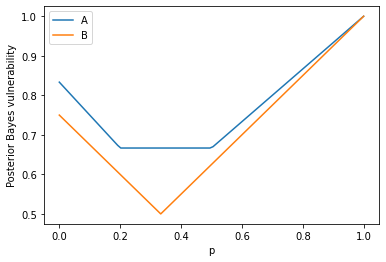

In [83]:
def get_pi(p):
    return np.array([p, (1-p)/2, (1-p)/2])

ps = np.linspace(0, 1, 100)
plt.plot(ps, [measure.bayes_vuln.posterior(get_pi(p), A) for p in ps], label="A")
plt.plot(ps, [measure.bayes_vuln.posterior(get_pi(p), B) for p in ps], label="B")
plt.xlabel('p')
plt.ylabel('Posterior Bayes vulnerability')
plt.legend()
None


So we see that $B$ is at least as safe as $A$ for all such priors. But maybe this phenomenon only happens for Bayes vulnerability?

Let's test it for a randomly generated gain function $g$.

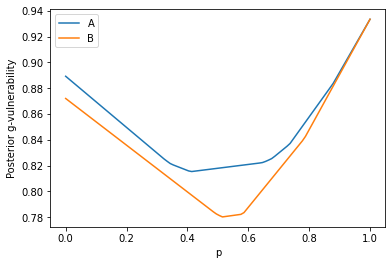

In [84]:
G = np.random.rand(8,3)    # A random gain function with 8 actions and 3 secrets

plt.plot(ps, [measure.g_vuln.posterior(G, get_pi(p), A) for p in ps], label="A")
plt.plot(ps, [measure.g_vuln.posterior(G, get_pi(p), B) for p in ps], label="B")
plt.xlabel('p')
plt.ylabel('Posterior g-vulnerability')
plt.legend()
None

Once again we have the same behaviour, $B$ is at least as safe as $A$.

But can we be confident that this is always the case? Indeed we can, because it turns out that $B$ is a __refinement__ of $A$ (written $A \sqsubseteq B$), as we can verify below:

In [85]:
print("Is A refined by B?", refinement.refined_by(A, B))

Is A refined by B? True


In fact, we can compute a channel $R$ such that $AR = B$.

In [86]:
R = channel.factorize(B, A)

print("Channel R:\n", R)
print("Is AR == B? ", np.all(A.dot(R) == B))

Channel R:
 [[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
Is AR == B?  True


Intuitively, the channel $R$ "forgets" the extra information of $A$, transforming it into $B$. Each output `X:Y` of $A$ is mapped to the output `?:Y` of $B$, simply ignoring the information of which door was chosen by the player.